# Use Machine Learning in a Trading Strategy

## Loading and Preparing the Data

In [98]:
# Import required libraries
import pandas as pd
from pathlib import Path

import pandas_datareader.data as web

In [99]:
# tickers = ('AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH','CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW')

ohlc = web.DataReader('MSFT', 'yahoo', start='1980-01-01')#, end='2023-01-01')

# Review the dataframe
ohlc.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1986-03-13,0.101563,0.088542,0.088542,0.097222,1.031789e+09,0.061109
1986-03-14,0.102431,0.097222,0.097222,0.100694,3.081600e+08,0.063292
1986-03-17,0.103299,0.100694,0.100694,0.102431,1.331712e+08,0.064384
1986-03-18,0.103299,0.098958,0.102431,0.099826,6.776640e+07,0.062746
1986-03-19,0.100694,0.097222,0.099826,0.098090,4.789440e+07,0.061655


In [100]:
# Calculate the daily returns using the closing prices and the pct_change function
ohlc["actual_returns"] = ohlc["Close"].pct_change()

# Display sample data
ohlc.head()

,High,Low,Open,Close,Volume,Adj Close,actual_returns
Date,,,,,,,
1986-03-13,0.101563,0.088542,0.088542,0.097222,1.031789e+09,0.061109,NaN
1986-03-14,0.102431,0.097222,0.097222,0.100694,3.081600e+08,0.063292,0.035712
1986-03-17,0.103299,0.100694,0.100694,0.102431,1.331712e+08,0.064384,0.017250
1986-03-18,0.103299,0.098958,0.102431,0.099826,6.776640e+07,0.062746,-0.025432
1986-03-19,0.100694,0.097222,0.099826,0.098090,4.789440e+07,0.061655,-0.017390


In [101]:
# Drop all NaN values from the DataFrame
ohlc = ohlc.dropna()

# Review the DataFrame
display(ohlc.head())
display(ohlc.tail())

,High,Low,Open,Close,Volume,Adj Close,actual_returns
Date,,,,,,,
1986-03-14,0.102431,0.097222,0.097222,0.100694,308160000.0,0.063292,0.035712
1986-03-17,0.103299,0.100694,0.100694,0.102431,133171200.0,0.064384,0.017250
1986-03-18,0.103299,0.098958,0.102431,0.099826,67766400.0,0.062746,-0.025432
1986-03-19,0.100694,0.097222,0.099826,0.098090,47894400.0,0.061655,-0.017390
1986-03-20,0.098090,0.094618,0.098090,0.095486,58435200.0,0.060018,-0.026547


,High,Low,Open,Close,Volume,Adj Close,actual_returns
Date,,,,,,,
2022-08-01,281.279999,275.839996,277.820007,278.010010,21539600.0,278.010010,-0.009724
2022-08-02,277.890015,272.380005,276.000000,274.820007,22754200.0,274.820007,-0.011474
2022-08-03,283.500000,276.609985,276.760010,282.470001,23518900.0,282.470001,0.027836
2022-08-04,283.799988,280.170013,281.799988,283.649994,18098700.0,283.649994,0.004177
2022-08-05,283.649994,278.679993,279.149994,282.910004,16762722.0,282.910004,-0.002609


## Generating the Features and Target Sets

### Creating the Features Set

In [106]:
# Define a window size of 4
short_window = 20

# Create an SMA that uses short_window, and assign it to a new column named “sma_fast”
ohlc["sma_fast"] = ohlc["Close"].rolling(window=short_window).mean()

In [107]:
# Define a window size of 20
long_window = 20

# Create an SMA that uses long_window, and assign it to a new columns named “sma_slow”
ohlc["sma_slow"] = ohlc["Close"].rolling(window=long_window).mean()

In [108]:
# Drop the NaNs using dropna()
ohlc = ohlc.dropna()

In [109]:
# Assign a copy of the `sma_fast` and `sma_slow` columns to a new DataFrame called `X`
X = ohlc[["sma_fast", "sma_slow"]].shift().dropna().copy()

# Display sample data
display(X.head())
display(X.tail())

,sma_fast,sma_slow
Date,,
1986-05-09 00:00:00,0.107357,0.107357
1986-05-12 00:00:00,0.107878,0.107878
1986-05-13 00:00:00,0.108398,0.108398
1986-05-14 00:00:00,0.108963,0.108963
1986-05-15 00:00:00,0.109310,0.109310


,sma_fast,sma_slow
Date,,
2022-08-01 00:00:00,262.213496,262.213496
2022-08-02 00:00:00,263.134998,263.134998
2022-08-03 00:00:00,263.733498,263.733498
2022-08-04 00:00:00,264.546498,264.546498
2022-08-05 00:00:00,265.308998,265.308998


### Creating the Target Set

In [110]:
# Create a new column in the `ohlc` called "signal" setting its value to zero.
ohlc["signal"] = 0.0

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [111]:
# Create the signal to buy
ohlc.loc[(ohlc["actual_returns"] >= 0), "signal"] = 1

C:\Users\Owner\anaconda3\envs\CurrentMain\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [112]:
# Create the signal to sell
ohlc.loc[(ohlc["actual_returns"] < 0), "signal"] = -1

In [113]:
# Copy the new "signal" column to a new Series called `y`.
y = ohlc["signal"].copy()
y

Date
1986-05-08    1.0
1986-05-09   -1.0
1986-05-12    1.0
1986-05-13    1.0
1986-05-14   -1.0
             ... 
2022-08-01   -1.0
2022-08-02   -1.0
2022-08-03    1.0
2022-08-04    1.0
2022-08-05   -1.0
Name: signal, Length: 9136, dtype: float64

## Split the Data into Training and Testing Sets

In [114]:
# Import required libraries
from pandas.tseries.offsets import DateOffset

In [115]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

1986-05-09 00:00:00


In [116]:
# Select the ending period for the training data with an offset of 18 months
training_end = X.index.min() + DateOffset(months=359) # APPRX 449 months of data

# Display the training end date
print(training_end)

2016-04-09 00:00:00


In [117]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [118]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]
y_test.head()

Date
2016-04-11   -1.0
2016-04-12    1.0
2016-04-13    1.0
2016-04-14    1.0
2016-04-15    1.0
Name: signal, dtype: float64

## Standardize the Data

In [119]:
# Import required libraries
from sklearn.preprocessing import StandardScaler

In [120]:
# Create a StandardScaler instance
scaler = StandardScaler()
 
# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
 
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

---

## Using Machine Learning Into a Trading Strategy

In [121]:
# Import the SVM model
from sklearn import svm
from sklearn.metrics import classification_report

In [122]:
# Create the classifier model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [123]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)

# Display the report
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.52      0.23      0.31      3611
         1.0       0.53      0.81      0.64      3931

    accuracy                           0.53      7542
   macro avg       0.52      0.52      0.48      7542
weighted avg       0.52      0.53      0.48      7542



### Backtesting a Machine Learning Trading Algorithm

In [124]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [125]:
# Evaluate the model's ability to predict the trading signal for the testing data
testing_report = classification_report(y_test, testing_signal_predictions)

# Display the report
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.47      0.22      0.30       713
         1.0       0.56      0.80      0.66       880

    accuracy                           0.54      1593
   macro avg       0.51      0.51      0.48      1593
weighted avg       0.52      0.54      0.49      1593



### Visually Compare the Actual and Predicted Returns

In [126]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = testing_signal_predictions

predictions_df["actual_returns"] = ohlc["actual_returns"]

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
predictions_df.head()

,predicted_signal,actual_returns,trading_algorithm_returns
Date,,,
2016-04-11 00:00:00,-1.0,-0.002021,0.002021
2016-04-12 00:00:00,-1.0,0.006260,-0.006260
2016-04-13 00:00:00,-1.0,0.012809,-0.012809
2016-04-14 00:00:00,-1.0,0.000181,-0.000181
2016-04-15 00:00:00,-1.0,0.005238,-0.005238


<AxesSubplot:xlabel='Date'>

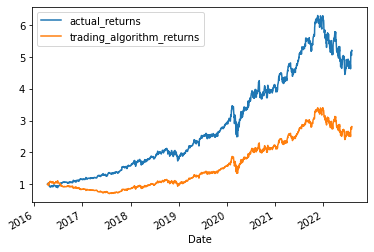

In [127]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()